In [1]:
from project_header import BearingNet, bearing_dataset, read_mat
from project_header.torch_tool.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import os

from torch import nn, optim
from torch.utils.data import DataLoader


## Set Dataloader

In [2]:
class_lst = ['Normal', 'Inner_break', 'Outer_break']
train = True
trainset = bearing_dataset(path = './data/Image/train', class_lst = class_lst, train = train)
TrainLoader = DataLoader(trainset, batch_size = 128)

Anchor is Normal, and Negative is Outer_break


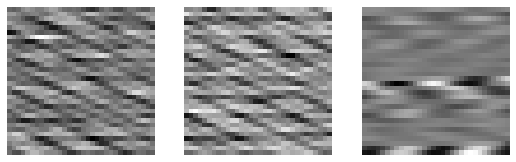

In [3]:
imgs = trainset[0]
print(f'Anchor is {class_lst[imgs[3]]}, and Negative is {class_lst[imgs[4]]}')
plt.figure(figsize = (9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[i].reshape(32, 32), cmap = 'gray')
    plt.axis('off')
# print(anchor.shape, pos.shape, neg.shape)
plt.show()

## Training encoding model
### 1. Define model

In [6]:
encode_size = 40
margin = 1.2
model = BearingNet(encode_size = encode_size, margin = margin)

if not os.path.isdir('./checkpoint'):
    os.mkdir('./checkpoint')

filepath = './checkpoint/model_{epoch}_{loss:.2f}.pth'

ckpt1 = ModelCheckpoint(
    filepath = filepath, monitor='loss', verbose=True,
    save_best_only = True, mode='auto', period=2
)

callbacks = [ckpt1]

----------------------------------
| The model use Cuda:0 to train. |
---------------------------------- 



### 2. Train model

In [7]:
history = model.fit_dataloader(TrainLoader, epochs = 30, callbacks = callbacks, verbose = True)

Epoch 1/30 :
[========================================] 100%	loss: 1.0464

Epoch 2/30 :
[========================================] 100%	loss: 0.8358

Epoch 3/30 :
[========================================] 100%	loss: 0.6702

Epoch 4/30 :
[========================================] 100%	loss: 0.5377

Epoch 5/30 :
[========================================] 100%	loss: 0.5130

Epoch 6/30 :
[========================================] 100%	loss: 0.4590

Epoch 7/30 :
[========================================] 100%	loss: 0.4519

Epoch 8/30 :
[========================================] 100%	loss: 0.4305

Epoch 9/30 :
[========================================] 100%	loss: 0.4165

Epoch 10/30 :
[========================================] 100%	loss: 0.4159

Epoch 11/30 :
[========================================] 100%	loss: 0.3740

Epoch 12/30 :
[========================================] 100%	loss: 0.3728

Epoch 13/30 :
[========================================] 100%	loss: 0.3948

Epoch 14/30 :
[======

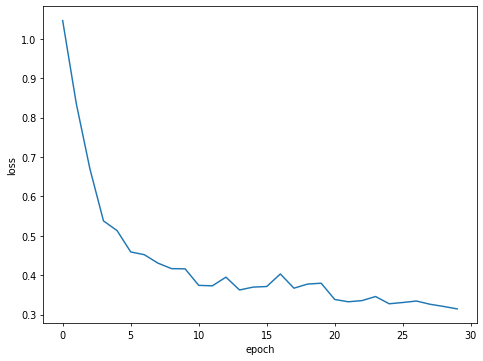

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 6), dpi = 70)
plt.plot(history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Get encoding vector from Normal, Inner_break, Outer_break for training Random Forest
1. read facenet model

In [9]:
import torch
from project_header import get_pattern

# read model
model = BearingNet(encode_size=encode_size)
model_path = './checkpoint/model_30_0.31.pth'
params = torch.load(model_path)
model.load_state_dict(params)
model.eval()

----------------------------------
| The model use Cuda:0 to train. |
---------------------------------- 



BearingNet(
  (cnn): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fully_connected): Sequential(
    (0): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=144, out_features=80, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=80, out_features=40, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Sigmoid()
  )
  (criterion): TripletMarginLoss()
)

2. encode all image by facenet

In [10]:
from project_header import get_dict

train_dict = get_dict(path = './data/Image/train')
class_lst = ['Normal', 'Inner_break', 'Outer_break']
label_lst = []
vec_lst = torch.zeros(1, encode_size)
count = 0

with torch.no_grad():
    for cla in class_lst:
        length = train_dict[cla].shape[0]
        label_lst += [count for _ in range(length)]
        vec = model(train_dict[cla])
        vec_lst = torch.cat([vec_lst, vec], dim = 0)
        count += 1

vec_lst = vec_lst[1:].numpy()
label_lst = np.array(label_lst)
print(vec_lst.shape, label_lst.shape)

(1071, 40) (1071,)


3. get pattern vector

In [11]:
pattern_vec_dict = get_pattern(model)

4. save encoding vector and label

In [12]:
path = './data/Vector'
np.save(f'{path}/x_train.npy', vec_lst)
np.save(f'{path}/y_train.npy', label_lst)

# Find the best threshold

In [39]:
from numpy.random import choice, randint

# ------- Fine the mean distance between same class and different class -------
# get vector dictionary
class_lst = list(train_dict.keys())[:-1]
x_train = np.load('./data/Vector/x_train.npy')
y_train = np.load('./data/Vector/y_train.npy')

vec_dict = dict()
for i in range(3):
    class_idx = np.where(y_train == i)[0]
    vec_dict[class_lst[i]] = x_train[class_idx]

# pick n image to test
n = 20000
same_cnt = 0
diff_cnt = 0

for i in range(n):
    test_class = choice(class_lst, size = 1)[0]
    test_idx = randint(len(vec_dict[test_class]))
    test_vec = vec_dict[test_class][test_idx]
    # print(f'------- Round {i}: test class is {test_class} -------')

    for class_name in class_lst:
        idx = randint(len(vec_dict[class_name]))
        vec = vec_dict[class_name][idx]

        dist = np.sqrt(np.sum((vec - test_vec) ** 2).mean())

        if class_name == test_class:
            same_cnt += dist
        else:
            diff_cnt += dist
        # print(f'Distance({test_class}, {class_name}) = {dist: .4f}')
    
same_cnt1 = same_cnt / n
diff_cnt1 = diff_cnt / (n * 2)
print(f'The mean distance between same class is {same_cnt1:.4f}')
print(f'The mean distance between different class is {diff_cnt1:.4f}')

The mean distance between same class is 0.1173
The mean distance between different class is 2.7699


In [41]:
from numpy.random import choice, randint
from joblib import load

# ------- Find the distance between the test vector and pattern vector -------
PatternVector = load('./data/Pattern_Vector/PatternVector.pth')
class_lst = list(train_dict.keys())[:-1]
x_train = np.load('./data/Vector/x_train.npy')
y_train = np.load('./data/Vector/y_train.npy')

vec_dict = dict()
for i in range(3):
    class_idx = np.where(y_train == i)[0]
    vec_dict[class_lst[i]] = x_train[class_idx]

# pick n image to test
n = 20000
same_cnt = 0
diff_cnt = 0

for i in range(n):
    test_class = choice(class_lst, size = 1)[0]
    test_idx = randint(len(vec_dict[test_class]))
    test_vec = vec_dict[test_class][test_idx]
    # print(f'------- Round {i}: test class is {test_class} -------')

    for class_name in class_lst:
        vec = PatternVector[class_name].numpy()

        dist = np.sqrt(np.sum((vec - test_vec) ** 2).mean())

        if class_name == test_class:
            same_cnt += dist
        else:
            diff_cnt += dist
        # print(f'Distance({test_class}, {class_name}) = {dist: .4f}')
    
same_cnt2 = same_cnt / n
diff_cnt2 = diff_cnt / (n * 2)
print(f'The mean distance between same class is {same_cnt2:.4f}')
print(f'The mean distance between different class is {diff_cnt2:.4f}')


The mean distance between same class is 0.0431
The mean distance between different class is 2.7754


In [42]:
best = (same_cnt1 + same_cnt2) / 2
print(f'The best threshold is {best:.4f}')

The best threshold is 0.0802


# Train Randomforest model

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Read data
path = './data/Vector'
X = np.load(f'{path}/x_train.npy')
Y = np.load(f'{path}/y_train.npy')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Define model
RF = RandomForestClassifier(
    n_estimators=150, criterion='gini', 
    max_depth=7, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
    max_features='sqrt', max_leaf_nodes=None, 
    min_impurity_decrease=0.1, min_impurity_split=None, 
    bootstrap=True, oob_score=False, 
    n_jobs=16, random_state=None, 
    class_weight=None, ccp_alpha=0.0
)

(856, 40) (215, 40) (856,) (215,)


In [25]:
# Training
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=7, max_features='sqrt',
                       min_impurity_decrease=0.1, n_estimators=150, n_jobs=16)

In [26]:
# Evaluation
pred = RF.predict(x_train)
print('Training report:')
print(classification_report(y_train, pred))

print()

pred = RF.predict(x_test)
print('Testing report:')
print(classification_report(y_test, pred))

Training report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      1.00      1.00       286
           2       1.00      1.00      1.00       284

    accuracy                           1.00       856
   macro avg       1.00      1.00      1.00       856
weighted avg       1.00      1.00      1.00       856


Testing report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00        73

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



In [27]:
from joblib import dump

dump(RF, './checkpoint/RF.pth')

['./checkpoint/RF.pth']